In [1]:
#Import needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0","Destination IP","Source IP","Timestamp","SimillarHTTP"],axis=1,inplace=True)
ddos_data=ddos_data.set_index('Flow ID')
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state = 15)
X_s = pca.fit_transform(X_s)


best k:  7  with corresponding silhouette:  0.6005188797984231


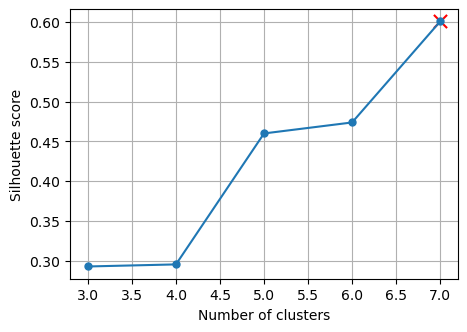

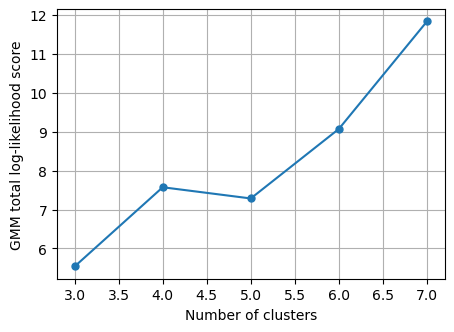

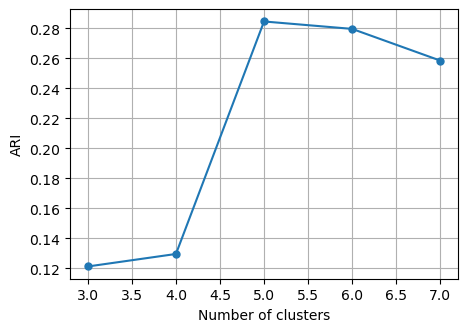

CPU times: user 1.16 s, sys: 1.6 s, total: 2.76 s
Wall time: 57.1 s


In [4]:

%%time
#GaussianMixture
#In this case use as hyper-parameter init_params = kmeans

#We computer the different scores for each iteration

n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

#we execute in parallel
from joblib import Parallel, delayed
def cluster_and_evaluate(n_clusters, X_s, y):
    gmm = GaussianMixture(n_components=n_clusters, init_params='kmeans', random_state = 42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

# Use Parallel and delayed to parallelize the loop
results = Parallel(n_jobs=-1)(delayed(cluster_and_evaluate)(n_clusters, X_s, y) for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, log_l_list = zip(*results)

#2. Plot the silhouette score

# Get n_clusters leading to the highest silhouette
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)


# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


In [5]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We computer the different scores for each iteration

# Function to perform GMM clustering and store metrics
def perform_gmm_clustering(n_clusters, X_s, y):
    gmm = GaussianMixture(n_components=n_clusters, init_params='random')
    cl_labels = gmm.fit_predict(X_s)

    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_l = gmm.score(X_s)

    return n_clusters, silhouette, ri, ari, log_l

# Initial broader search
n_cluster_list = []
shs_list = []
ri_list = []
ari_list = []
log_l_list = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_initial = Parallel(n_jobs=-1)(delayed(perform_gmm_clustering)(n_clusters, X_s, y) for n_clusters in initial_search_range)

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, log_l_list = zip(*results_initial)

# Find the best initial k
best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
print("Best refined k: ", best_n, " with corresponding silhouette: ", best_sh, " ri: ", best_ri, " ari: ", best_ari, )


# Refine search around the best k found
refined_n_cluster_list = []
refined_shs_list = []
refined_ri_list = []
refined_ari_list = []
refined_log_l_list = []

# Define the refined range
refined_range = range(max(3, best_n - 2), min(16, best_n + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined = Parallel(n_jobs=-1)(delayed(perform_gmm_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list, refined_shs_list, refined_ri_list, refined_ari_list, refined_log_l_list = zip(*results_refined)


# Find the best refined k
best_refined_sh = np.max(refined_shs_list)
best_refined_n = refined_n_cluster_list[np.argmax(refined_shs_list)]
best_refined_ri = refined_ri_list[np.argmax(refined_shs_list)]
best_refined_ari = refined_ari_list[np.argmax(refined_shs_list)]
print("Best refined k: ", best_refined_n, " with corresponding silhouette: ", best_refined_sh, " ri: ", best_refined_ri, " ari: ", best_refined_ari, )


# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


NameError: name 'best_ri' is not defined

Best initial k:  12  with corresponding silhouette:  0.664939761598921
Best refined k:  11  with corresponding silhouette:  0.6593410033745802


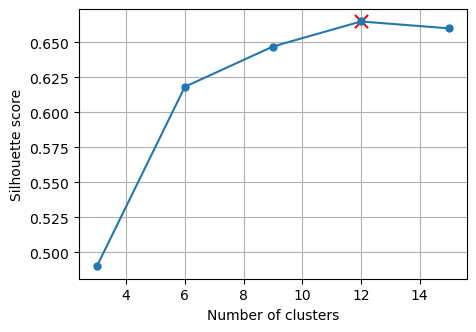

CPU times: user 271 ms, sys: 126 ms, total: 398 ms
Wall time: 1min 52s


In [6]:
%%time

#K-means

# Function to perform KMeans clustering and store metrics
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans.fit_predict(X_s)

    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_

    return n_clusters, silhouette, ri, ari, inertia

# Step 1: Initial broader search
n_cluster_list = []
shs_list = []
ri_list = []
ari_list = []
inertia_list = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results = Parallel(n_jobs=-1)(delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, inertia_list = zip(*results)

# Get n_clusters leading to the highest silhouette
best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
print("Best initial k: ", best_n, " with corresponding silhouette: ", best_sh)

# Step 2: Refine search around the best k found
refined_n_cluster_list = []
refined_shs_list = []
refined_ri_list = []
refined_ari_list = []
refined_inertia_list = []

# Define the refined range around the best k
refined_range = range(max(3, best_n - 2), min(16, best_n + 3))
    
# Use Parallel and delayed to parallelize the loop for the refined search
results_refined = Parallel(n_jobs=-1)(delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list, refined_shs_list, refined_ri_list, refined_ari_list, refined_inertia_list = zip(*results_refined)

# Get the best refined k
best_refined_sh = np.max(refined_shs_list)
best_refined_n = refined_n_cluster_list[np.argmax(refined_shs_list)]
print("Best refined k: ", best_refined_n, " with corresponding silhouette: ", best_refined_sh)


# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [7]:
%%time

# Utilizziamo quindi il modello KMeans

# è stato deciso che 12 è il migliore dal precedente punto.
model = KMeans(n_clusters=12)

# Ottieni le etichette del cluster
cluster_labels = model.fit_predict(X_s)

# Calcola le metriche di clustering
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

# Stampa le metriche
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")


Silhouette Score: 0.6250962229580632
Adjusted Rand Index: 0.25350005123172376
CPU times: user 2min 13s, sys: 6min 34s, total: 8min 47s
Wall time: 1min 35s


In [8]:
%%time


# Analizza il numero di flussi per cluster
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 4.16 ms, sys: 4.34 ms, total: 8.51 ms
Wall time: 8.07 ms


In [ ]:
%%time

# Plot ECDF per il numero di flussi per cluster
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
plt.title('ECDF of Number of Flows per Cluster')
plt.xlabel('Number of Flows')
plt.ylabel('ECDF')
plt.show()